In [2]:
import numpy as np
import random
import json
import sys
import time
import importlib
import argparse
import pathlib
#import config
from matplotlib import pyplot as plt


from enviroment import fastMRIEnviroment
from VAE import CVAE
from MDNRNN import MDNRNN
from controller import Controller
from world_model import make_model
from fastmri_data import get_test_images_vae, get_random_accelerations

VAE_DIM
ACTION_DIM=2
REWARD_DIM=0

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
model=make_model()
model.load_model('./controller/fastmri.cma.1.4.best.json')

Instructions for updating:
Colocations handled automatically by placer.
Completed creating VAE the model
Image dir exits
Tensor("input_5:0", shape=(?, 256, 256), dtype=float32)
Print hidden
Tensor("lstm/while/Exit_2:0", shape=(?, 256), dtype=float32)
Tensor("lstm/strided_slice_15:0", shape=(?, 256), dtype=float32)
Instructions for updating:
Use tf.cast instead.
Completed creating MDNRNN model
loading file ./controller/fastmri.cma.1.4.best.json


In [4]:
test_datadir='/media/DATA/ML_data/fastmri/singlecoil/test/singlecoil_test_v2'


filenames = list(pathlib.Path(test_datadir).iterdir())


#pathway 
# load the file
# select random actions:
# obtain observation: 
# get optimal actions 
# #reconstruct

/media/DATA/ML_data/fastmri/singlecoil/test/singlecoil_test_v2/file1002091_v2.h5
Centre fraction:0.01022610972771133
Acceleration factor:3.0
(36, 256, 256, 1)


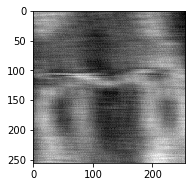

In [6]:
print(filenames[10])
a1,a2=get_random_accelerations(high=10)
print("Centre fraction:" + str(a1)) 
print("Acceleration factor:" + str(a2))
test_images=  get_test_images_vae(filenames[1], a1, a2)

print(np.shape(test_images))

plt.subplot(1,2,1)
plt.imshow(test_images[20,:,:, 0], cmap='gray') 

In [9]:
vae_encoded_obs=model.update(test_images[:,:,:,0], t=0)
reward=0

batch_size=np.shape(vae_encoded_obs)[0]
actions = np.ones(shape=(batch_size, ACTION_DIM))
actions[:, 0] = a1
actions[:, 1] = a2
rewards = np.ones(shape=(batch_size, 1)) * reward

a = np.concatenate([np.squeeze(vae_encoded_obs), actions, rewards], axis=1)
np.shape(a)

In [11]:
hidden=np.zeros(shape=(batch_size, model.rnn.hidden_units))
cell_state = np.zeros(shape=(batch_size, model.rnn.hidden_units))

DIM = VAE_DIM + ACTION_DIM + REWARD_DIM
merged_input = np.reshape(a, [batch_size, 1, DIM])
y_pred_rnn, rnn_hidden, rnn_cell = model.rnn.predict(merged_input, hidden,cell_state)

(36, 64)

In [ ]:
controller_obs = np.concatenate([np.mean(vae_encoded_obs, axis=0), np.mean(rnn_hidden,axis=0)])
action = model.get_action(controller_obs, t=0, add_noise=False)
recons_next_z=model.vae.r(y_pred_rnn)
